In [62]:
# Instalar las librerías si no las tienes
install.packages("dagitty")
install.packages("tidyverse") 
install.packages("broom")     
install.packages("knitr")     

# Cargar las librerías en tu sesión
library(dagitty)
library(tidyverse)
library(broom)
library(knitr)
library(stargazer)
library(dplyr)
library(ggplot2)


Warning message:
"package 'dagitty' is in use and will not be installed"
Warning message:
"package 'tidyverse' is in use and will not be installed"


Warning message:
"package 'broom' is in use and will not be installed"
Warning message:
"package 'knitr' is in use and will not be installed"


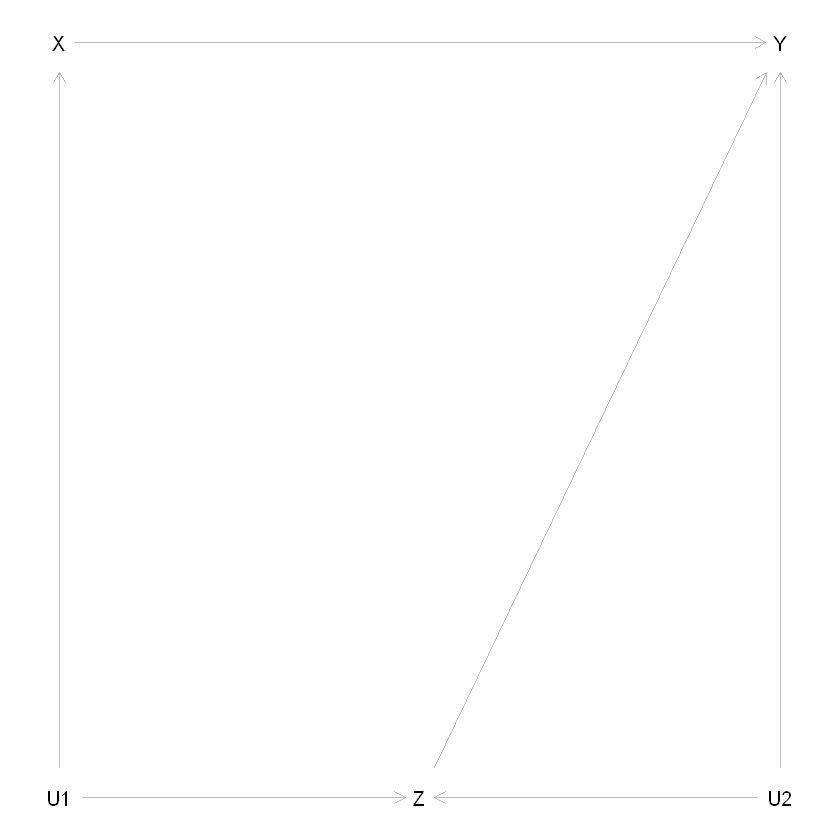

In [45]:
# DAG original
dag_original <- dagitty('dag {
  U1 -> X
  U1 -> Z
  U2 -> Z
  U2 -> Y
  X -> Y
  Z -> Y
}')

# Coordenadas
coordinates(dag_original) <- list(
  x = c(U1 = 0, Z = 1, U2 = 2, X = 0, Y = 2),
  y = c(U1 = 2, Z = 2, U2 = 2, X = 0, Y = 0)
)
plot(dag_original)


In [ ]:
# Simulación de datos para el grafo original
set.seed(111)
n_samples <- 100000
true_effect_original <- 1

U1 <- rnorm(n_samples)
U2 <- rnorm(n_samples)
Z  <- 0.6 * U1 + 0.5 * U2 + rnorm(n_samples)
X  <- 0.8 * U1 + rnorm(n_samples)
Y  <- true_effect_original * X + 0.4 * Z + 0.9 * U2 + rnorm(n_samples)

df_original <- tibble(X, Y, Z)



In [55]:
## 1.2 Regresiones con y sin control 
model_sin_Z <- lm(Y ~ 0 + X, data = df_original)
model_con_Z <- lm(Y ~ 0 + X + Z, data = df_original)

stargazer(model_sin_Z, model_con_Z, 
          type = "text",
          title = "Comparación de modelos",
          column.labels = c("Sin Z", "Con Z"))



Comparación de modelos
                                        Dependent variable:                     
                    ------------------------------------------------------------
                                                 Y                              
                                Sin Z                          Con Z            
                                 (1)                            (2)             
--------------------------------------------------------------------------------
X                              1.054***                      1.001***           
                               (0.003)                        (0.003)           
                                                                                
Z                                                            0.400***           
                                                              (0.003)           
                                                                                
----

Intervalos de Confianza (99%):
# A tibble: 2 × 4
  Model      estimate conf.low conf.high
  <chr>         <dbl>    <dbl>     <dbl>
1 Y vs. X        1.05    1.05       1.06
2 Y vs. X, Z     1.00    0.994      1.01

Gráfico exportado a 'output/part3_coefficients_plot_R.png'



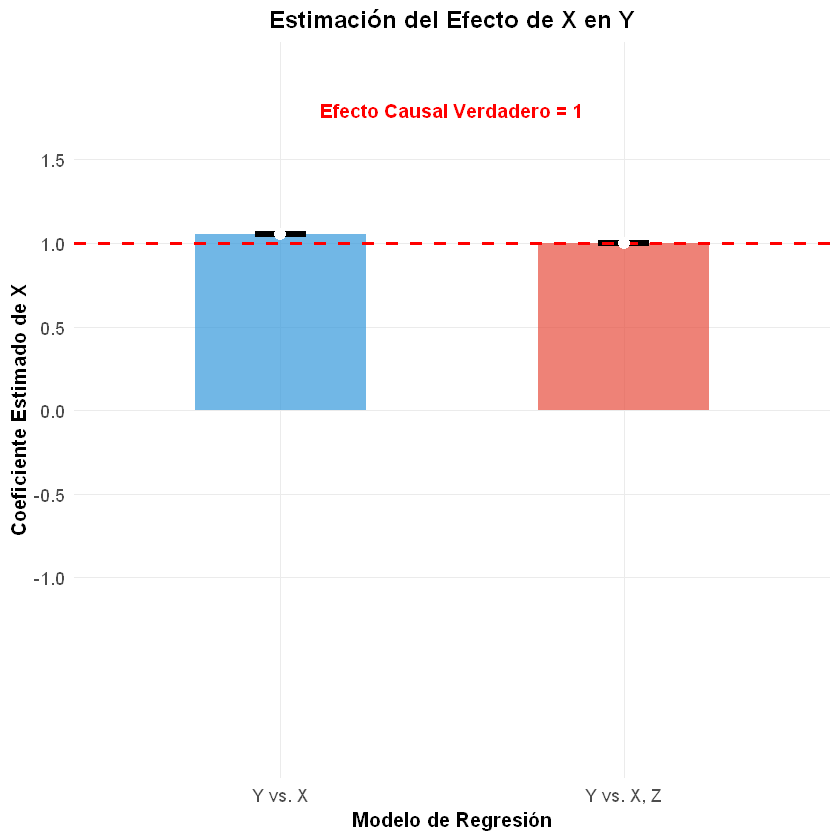

In [73]:
## 1.3 Gráfico de Coeficientes vs. Efecto Verdadero 

# Crear un dataframe con los resultados para graficar
plot_data_original <- bind_rows(
  tidy(model_sin_Z, conf.int = TRUE, conf.level = 0.99) %>% mutate(Model = "Y vs. X"),
  tidy(model_con_Z, conf.int = TRUE, conf.level = 0.99) %>% mutate(Model = "Y vs. X, Z")
) %>%
  filter(term == "X")

# Mostrar los datos para verificar los intervalos
cat("Intervalos de Confianza (99%):\n")
print(plot_data_original %>% 
      select(Model, estimate, conf.low, conf.high) %>%
      mutate(across(where(is.numeric), ~round(.x, 4))))

# gráfico
coefficients_plot <- ggplot(plot_data_original, aes(x = Model, y = estimate)) +
  geom_col(aes(fill = Model), alpha = 0.7, width = 0.5) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), 
                width = 0.15, linewidth = 1.2, color = "black") +
  geom_hline(yintercept = true_effect_original, linetype = "dashed", 
             color = "red", linewidth = 1) +
  geom_point(aes(y = estimate), size = 3, color = "white") +  # Punto en la estimación
  annotate("text", x = 1.5, y = 1.8, 
           label = paste("Efecto Causal Verdadero =", true_effect_original), 
           color = "red", size = 4, fontface = "bold") +
  scale_y_continuous(limits = c(-2, 2), breaks = seq(-1, 1.5, 0.5)) +  # Limitar eje y
  scale_fill_manual(values = c("Y vs. X" = "#3498db", "Y vs. X, Z" = "#e74c3c")) +
  labs(
    title = "Estimación del Efecto de X en Y",
    y = "Coeficiente Estimado de X",
    x = "Modelo de Regresión"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5),
    panel.grid.minor = element_blank(),
    axis.text = element_text(size = 11),
    axis.title = element_text(size = 12, face = "bold")
  )

print(coefficients_plot)

# Guardar el gráfico en la carpeta 'output'
if (!dir.exists("output")) {dir.create("output")}
ggsave("output/part3_coefficients_plot_R.png", plot = coefficients_plot, 
       width = 10, height = 6, dpi = 300)
cat("\nGráfico exportado a 'output/part3_coefficients_plot_R.png'\n\n")


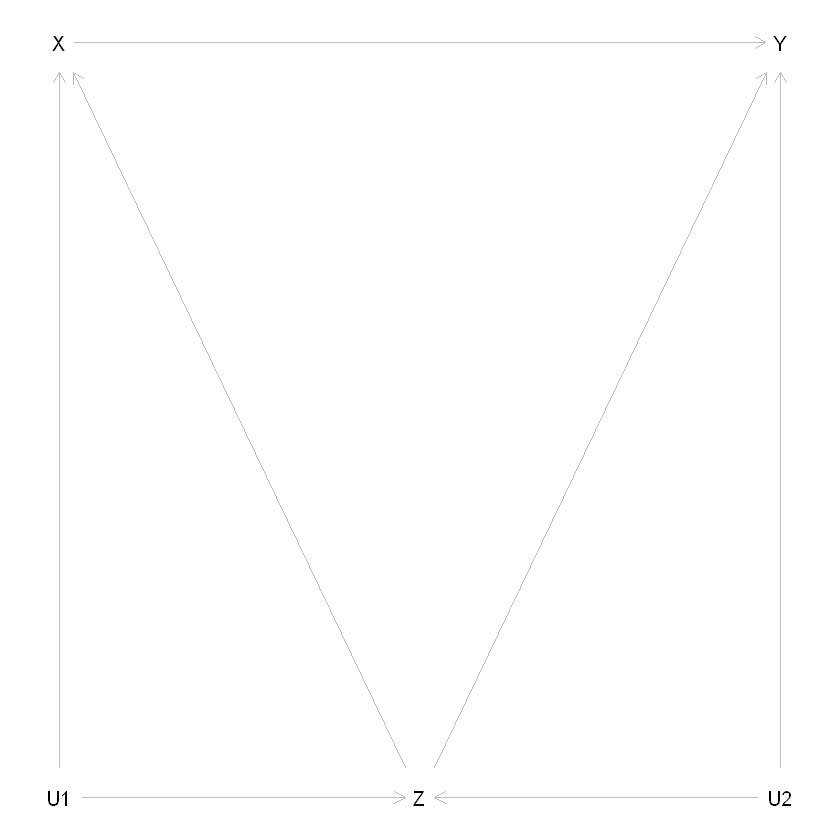

In [74]:
#  2. DAG Modificado con Controles Observables 
## 2.1 DAG modificado
dag_2 <- dagitty('dag {
  U1 -> X
  U1 -> Z
  U2 -> Z
  U2 -> Y
  X -> Y
  Z -> Y
  Z -> X
}')

# Coordenadas exactas para mantener el mismo layout
coordinates(dag_2) <- list(
  x = c(U1 = 0, Z = 1, U2 = 2, X = 0, Y = 2),
  y = c(U1 = 2, Z = 2, U2 = 2, X = 0, Y = 0)
)

plot(dag_2)

In [84]:
# Simulación donde U1 y U2 son observables
set.seed(456)
true_effect_modificado <- 1

U1 <- rnorm(n_samples)
U2 <- rnorm(n_samples)
Z  <- 1 * U1 + 1 * U2 + rnorm(n_samples)
X  <- 1 * U1 + 1 * Z + rnorm(n_samples)
Y  <- true_effect_modificado * X + 1 * Z + 1 * U2 + rnorm(n_samples)

df_modified <- tibble(X, Y, Z, U1, U2)
## 2.2 Correr las 8 Regresiones 
formulas <- list(
  "Ninguno"      = Y ~ 0 + X,
  "Z"         = Y ~ 0 + X + Z,
  "U1"        = Y ~ 0 + X + U1,
  "U2"        = Y ~ 0 + X + U2,
  "Z, U1"     = Y ~ 0 + X + Z + U1,
  "Z, U2"     = Y ~ 0 + X + Z + U2,
  "U1, U2"    = Y ~ 0 + X + U1 + U2,
  "Z, U1, U2" = Y ~ 0 + X + Z + U1 + U2
)

# Correr todos los modelos y extraer los coeficientes de X
results_df <- formulas %>%
  map_dfr(~ tidy(lm(.x, data = df_modified)), .id = "Controls") %>%
  filter(term == "X") %>%
  select(Controls, beta = estimate, SE = std.error) %>%
  column_to_rownames(var = "Controls")



In [109]:
## 2.3 Guardar y Presentar la Tabla de Resultados
print("--- Tabla de Resultados: Escenario Modificado ---")
print(paste("El efecto causal verdadero es:", true_effect_modificado))
kable(results_df, caption = "Resultados de Regresiones segun  que control se usa", booktabs = TRUE)
write.table(results_df, "output/regression_results_R.txt", sep = "\t", quote = FALSE)
print(" Tabla exportada a 'output/regression_results_R.txt'")



[1] "--- Tabla de Resultados: Escenario Modificado ---"
[1] "El efecto causal verdadero es: 1"




Table: Resultados de Regresiones segun  que control se usa

|          |      beta|        SE|
|:---------|---------:|---------:|
|Ninguno   | 1.7125568| 0.0022150|
|Z         | 0.7956490| 0.0030920|
|U1        | 2.0018608| 0.0031735|
|U2        | 1.4986126| 0.0015718|
|Z, U1     | 0.9982973| 0.0038703|
|Z, U2     | 0.9994591| 0.0025708|
|U1, U2    | 1.4971942| 0.0027353|
|Z, U1, U2 | 0.9991108| 0.0031503|

[1] " Tabla exportada a 'output/regression_results_R.txt'"


In [111]:
## 2.4 Análisis: ¿Qué controles funcionan? 
tolerance <- 0.02  #valor arbitrario pero que consideramos es aceptable
good_controls_df <- results_df %>%
  filter(abs(beta - true_effect_modificado) < tolerance)

print("--- Conjuntos de Controles con Estimaciones Correctas ---")
kable(good_controls_df)



[1] "--- Conjuntos de Controles con Estimaciones Correctas ---"




|          |      beta|        SE|
|:---------|---------:|---------:|
|Z, U1     | 0.9982973| 0.0038703|
|Z, U2     | 0.9994591| 0.0025708|
|Z, U1, U2 | 0.9991108| 0.0031503|

In [ ]:
## 2.5 Análisis: ¿Cuál es el conjunto mínimo suficiente?
# seria el conjunto de control {Z, U2}  o {Z, U1}

# pero si queremos que sea con codigo que se actualiza: 
good_sets_list <- rownames(good_controls_df) %>%
  str_split(", ")

minimal_sufficient_sets <- good_sets_list %>%
  keep(~ {
    current_set <- .x
    # Es mínimo si ningún OTRO conjunto bueno es un subconjunto de él
    !any(map_lgl(good_sets_list, ~ all(.x %in% current_set) && !identical(.x, current_set)))
  })

print("--- Conjunto(s) Mínimo(s) Suficiente(s) ---")
print(minimal_sufficient_sets)




[1] "--- Conjunto(s) Mínimo(s) Suficiente(s) ---"
[[1]]
[1] "Z"  "U1"

[[2]]
[1] "Z"  "U2"



### Provide intuition on why you can get good estimates controlling for the variables you stablished abov
Para obtener una estimación correcta del efecto de X en Y, necesitamos cerrar todos los caminos de puerta trasera "backdoor path" que crean una conexión falsa entre ellos.

Observando el DAG, un primer impulso sería controlar por Z, ya que participa en varios de estos caminos. Sin embargo, Z es un collider en la ruta que conecta U1 y U2. Controlar por un collider es problemático porque abre este camino que antes estaba cerrado, creando un nuevo backdoor path espurio entre X y Y a través de U1 y U2.

La solución es usar el conjunto de controles {Z, U1}. Esta combinación funciona porque realiza dos acciones clave simultáneamente: el control sobre Z cierra los backdoor paths originales, mientras que el control sobre U1 cierra inmediatamente el nuevo camino que fue abierto por el colisionador. De esta manera, se neutralizan todas las conexiones espurias y se aísla el verdadero efecto causal de X sobre Y. Pasa similar  con {Z, U2}